# Ratio Put-Spread Strategy

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [2]:
import options_wizard as ow
import pandas as pd

universe = ow.Universe(['AAPL'])
#universe.top_constituents(10)
#universe.check_ticks()
data_manager = ow.DataManager(universe, load_lazy=True)
len(data_manager.universe.ticks)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


1

#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits', upper_date = pd.Timestamp('2021-01-01'))
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', upper_date=pd.Timestamp('2021-01-01').tz_localize('America/New_York'), drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [4]:
ow.Strategy(data_manager)('ratio_spread', lower_ttm=91, upper_ttm=121, delta_atm=0.3, delta_otm=0.1, otm_ratio=2, hold_period=30, call_put='p')
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, entry_cost_size='short', entry_notional='underlying', initial_capital=1_000_000.0, capital_per_trade=12/(256), all_returns=True)
ow.Backtest(data_manager)("multi_stock", initial_capital=0,entry_notional = True, fixed_notional_exposure = 1_000_000*12/252,  allocation_basis="short")

#### __Model prediction and Pipeline Execution__
The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [ ]:
data_manager.execute_pipeline(retain_data=False, save_data=False, n_workers=4)

Deferring method multi_stock for all stocks

#### __Result Visualisation__ 

C:\Users\cameronA\AppData\Local\Temp\ipykernel_4592\1048033525.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^NDX", start=start, end=end, progress=False)['Close']


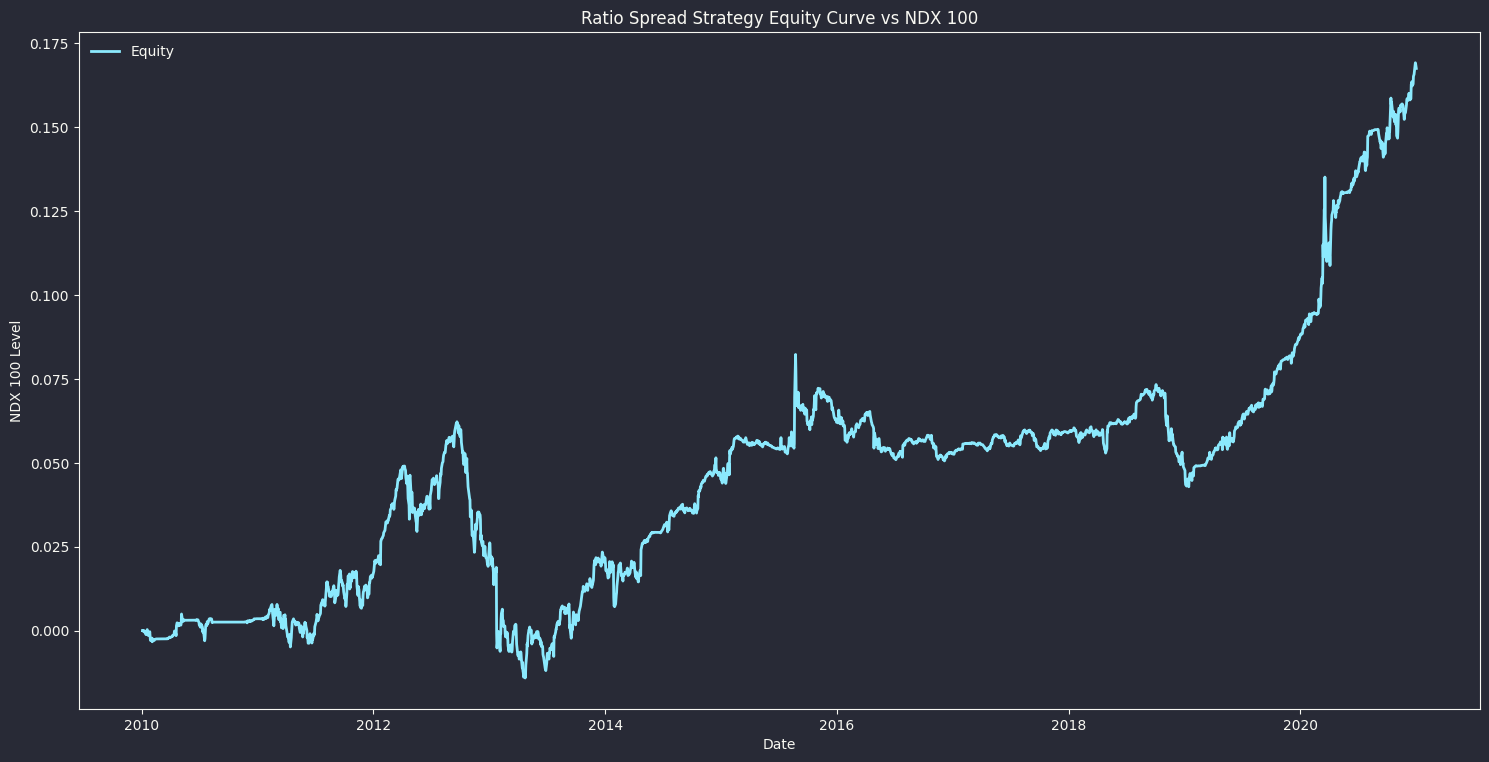

In [ ]:
start = "2010-01-01"
end   = "2022-01-01"

import numpy as np
import matplotlib.pyplot as plt
import matplotx

plt.style.use(matplotx.styles.dracula)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

equity_combined = data_manager.combined_outputs['multi_stock']['equity']
equity_combined.index = pd.to_datetime(equity_combined.index)
equity_combined = equity_combined.loc[start_dt:end_dt]

fig, ax1 = plt.subplots(figsize=(15, 7.5))


#for tick in universe.ticks:
#    equity_tick = data_manager.outputs[tick]['equity']
#    equity_tick.index = pd.to_datetime(equity_tick.index)
#    equity_tick = equity_tick.loc[start_dt:end_dt]
#    ax1.plot(equity_tick, label=f"{tick}", alpha=0.5)

#ax1.plot(equity_combined, label="Strat", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value")

ax1.grid(True)
handles, labels = ax1.get_legend_handles_labels()
ncols = int(np.ceil(len(labels) / 10))
#ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=ncols, frameon=False)
import yfinance as yf

sp500 = yf.download("^NDX", start=start, end=end, progress=False)['Close']
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.loc[start_dt:end_dt]

ax1.plot(data_manager.combined_outputs['multi_stock']['equity'], label='Equity', linewidth=2)
#ax1.plot(data_manager.combined_outputs['multi_stock']['underlying_equity'], label='NDX 100 Level', linewidth=2)
#ax1.plot(data_manager.combined_outputs['multi_stock']['equity_with_underlying'] - 1_000_000, label='Combined-Strat', linewidth=2)
#(1_000_000*np.exp(data_manager.combined_outputs['multi_stock']['daily_log_return'].cumsum())).plot(ax=ax1)
ax1.set_ylabel("NDX 100 Level", )
ax1.tick_params(axis='y')
ax1.grid(False)

fig.tight_layout()
plt.legend()
plt.title("Ratio Spread Strategy Equity Curve vs NDX 100")
plt.show()

C:\Users\cameronA\AppData\Local\Temp\ipykernel_4592\3976878056.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_j = eq_series[j]


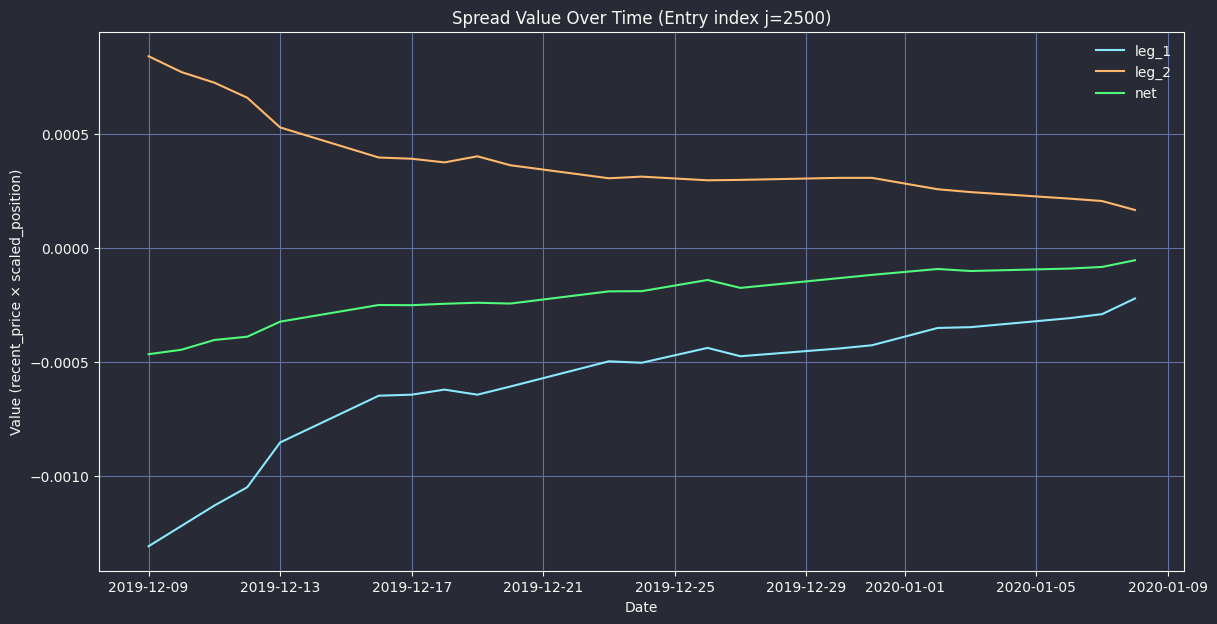

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

eq_series = data_manager.combined_outputs['multi_stock']['equity_obj']

# ---- choose the entry index ----
j = 2500

# ---- identify contracts entered on day j ----
ss_j = eq_series[j]
entry_day = ss_j.date.date()

entered_today = [
    c for c in ss_j.active_contracts
    if c.entry_date.date() == entry_day
]

if not entered_today:
    print("No contracts entered on this day.")
    raise SystemExit

# ---- define a stable key for each contract leg ----
def key(c):
    return (
        c.expiry_date_idx,
        c.strike_idx,
        c.call_put_idx,
        c.base_position,
        c.entry_date.date()
    )

target_keys = { key(c) for c in entered_today }

# ---- track contracts forward in time ----
records = []

for ss in eq_series[j:]:
    current_legs = [c for c in ss.active_contracts if key(c) in target_keys]
    
    if len(current_legs) == 0 and len(records) > 1:
        break

    records.append((ss.date, current_legs))

# ---- build a DataFrame of leg values ----
rows = []

for dt, legs in records:
    row = {"date": dt}
    total_value = 0.0
    
    for i, c in enumerate(legs):
        val = c.recent_price * c.scaled_position
        row[f"leg_{i+1}"] = val
        total_value += val

    row["net"] = total_value
    rows.append(row)

df = pd.DataFrame(rows).set_index("date")

# ---- plot ----
plt.figure(figsize=(14, 7))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)

plt.title(f"Spread Value Over Time (Entry index j={j})")
plt.xlabel("Date")
plt.ylabel("Value (recent_price × scaled_position)")
plt.legend()
plt.grid(True)
plt.show()


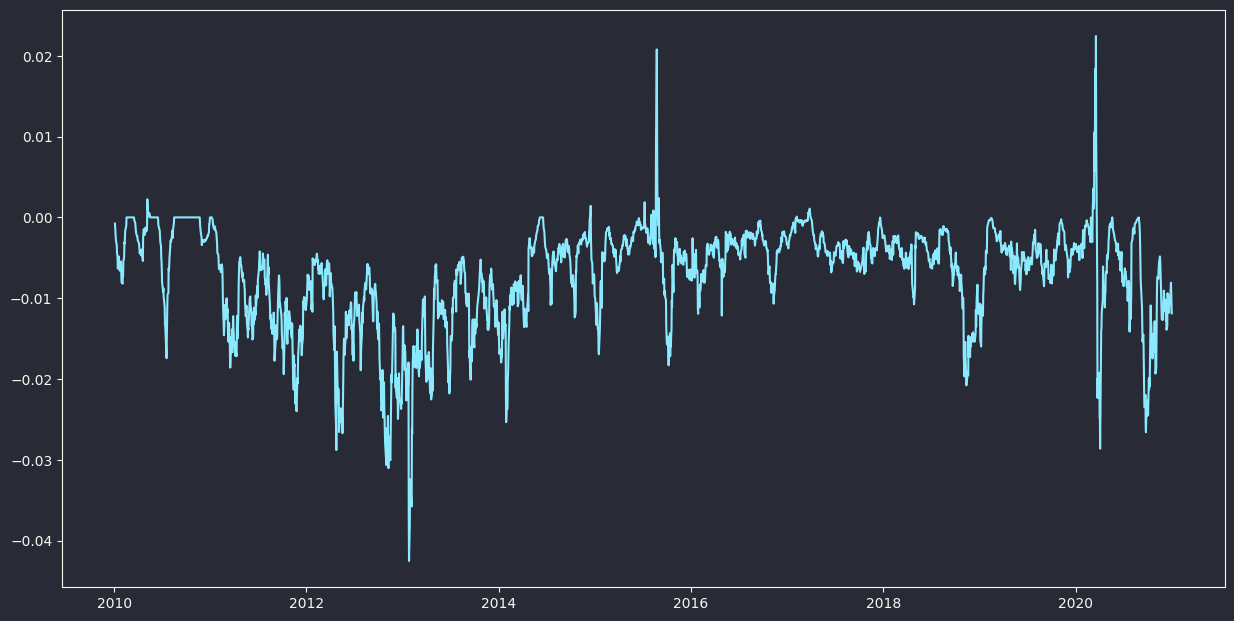

In [ ]:
pos_val = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.recent_price
        for c in x.active_contracts
    )
)

plt.figure(figsize=(15,7.5))
plt.plot(pos_val)

In [ ]:
data_manager.combined_outputs['multi_stock']['equity_obj'][0]

C:\Users\cameronA\AppData\Local\Temp\ipykernel_4592\4255121645.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_manager.combined_outputs['multi_stock']['equity_obj'][0]


SubStrategy(date=Timestamp('2010-01-04 00:00:00'), active_contracts=[TradedContract(expiry_date_idx=Timestamp('2010-04-17 00:00:00-0400', tz='America/New_York'), call_put_idx='p', strike_idx=195.0, base_position=-1.0, entry_date=Timestamp('2010-01-04 00:00:00-0500', tz='America/New_York'), exit_date=Timestamp('2010-02-03 00:00:00-0500', tz='America/New_York'), scaled_position=-0.006230238511240511, recent_price=0.3, last_price=0.3, delta=-0.2819, theta=-0.0691, vega=0.3863, underlying_close=7.643214225769043, has_price_today=True, trade_date_idx=Timestamp('2010-01-04 00:00:00-0500', tz='America/New_York')), TradedContract(expiry_date_idx=Timestamp('2010-04-17 00:00:00-0400', tz='America/New_York'), call_put_idx='p', strike_idx=165.0, base_position=2.0, entry_date=Timestamp('2010-01-04 00:00:00-0500', tz='America/New_York'), exit_date=Timestamp('2010-02-03 00:00:00-0500', tz='America/New_York'), scaled_position=0.012460477022481022, recent_price=0.08857142857142858, last_price=0.0885714

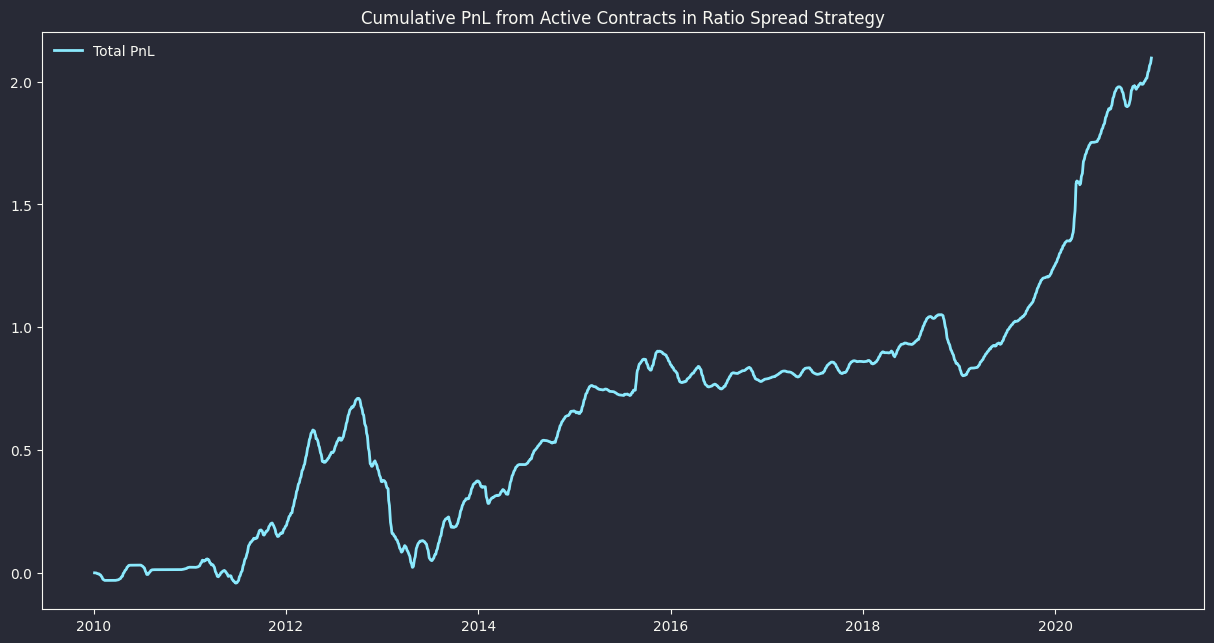

In [ ]:
pos_val = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts
    )
)

pnl_shorts = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position < 0
    )
)

pnl_longs = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position > 0
    )
)

plt.figure(figsize=(15,7.5))
#plt.plot(pnl_longs.cumsum(), label='Long PnL')
#plt.plot(pnl_shorts.cumsum(), label='Short PnL')
plt.plot(pos_val.cumsum(), label='Total PnL', linewidth=2)
plt.title("Cumulative PnL from Active Contracts in Ratio Spread Strategy")
plt.legend()

In [ ]:
delta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.delta * c.underlying_close
        for c in x.active_contracts
    ) / sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) if sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) != 0 else 0.0
)
theta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.theta
        for c in x.active_contracts
    )
)

vega = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.vega
        for c in x.active_contracts
    )
)

def as_naive_date(ts):
    ts = pd.to_datetime(ts)
    return ts.tz_localize(None).normalize() if ts.tzinfo else ts.normalize()

entry_cost = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.last_price
        for c in x.active_contracts
        if as_naive_date(c.entry_date) == as_naive_date(x.date)
    )
)

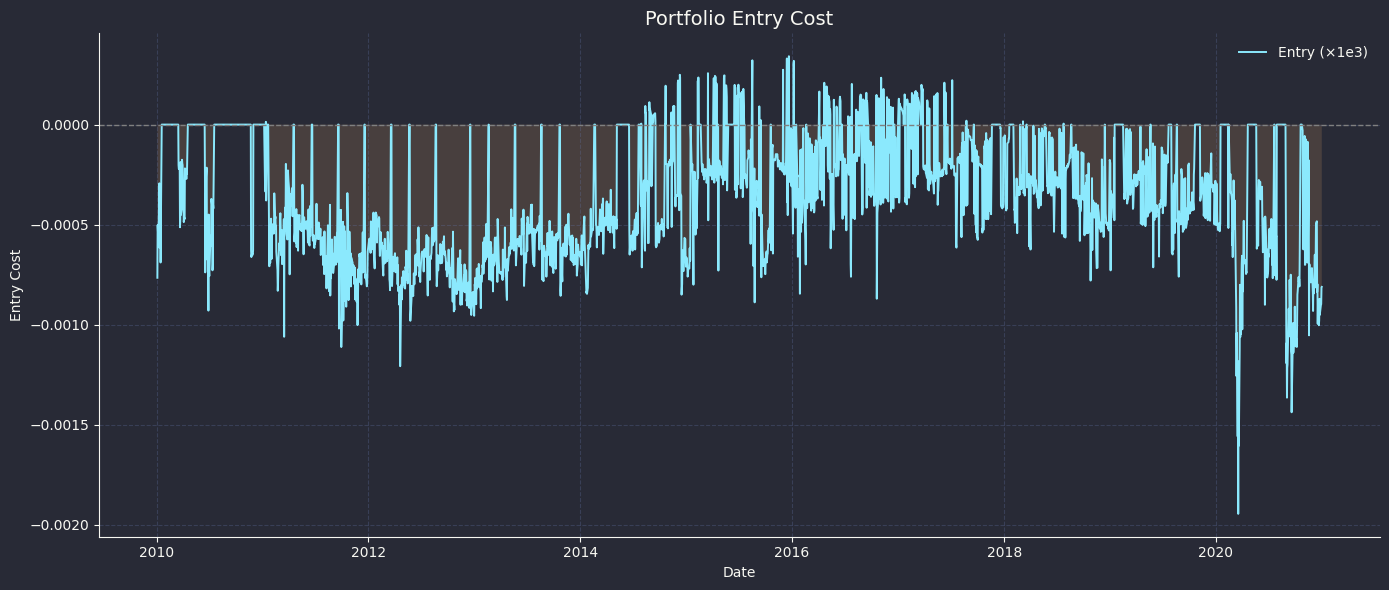

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(entry_cost.index, entry_cost, linewidth=1.4, label='Entry (×1e3)')
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Entry Cost', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Entry Cost')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

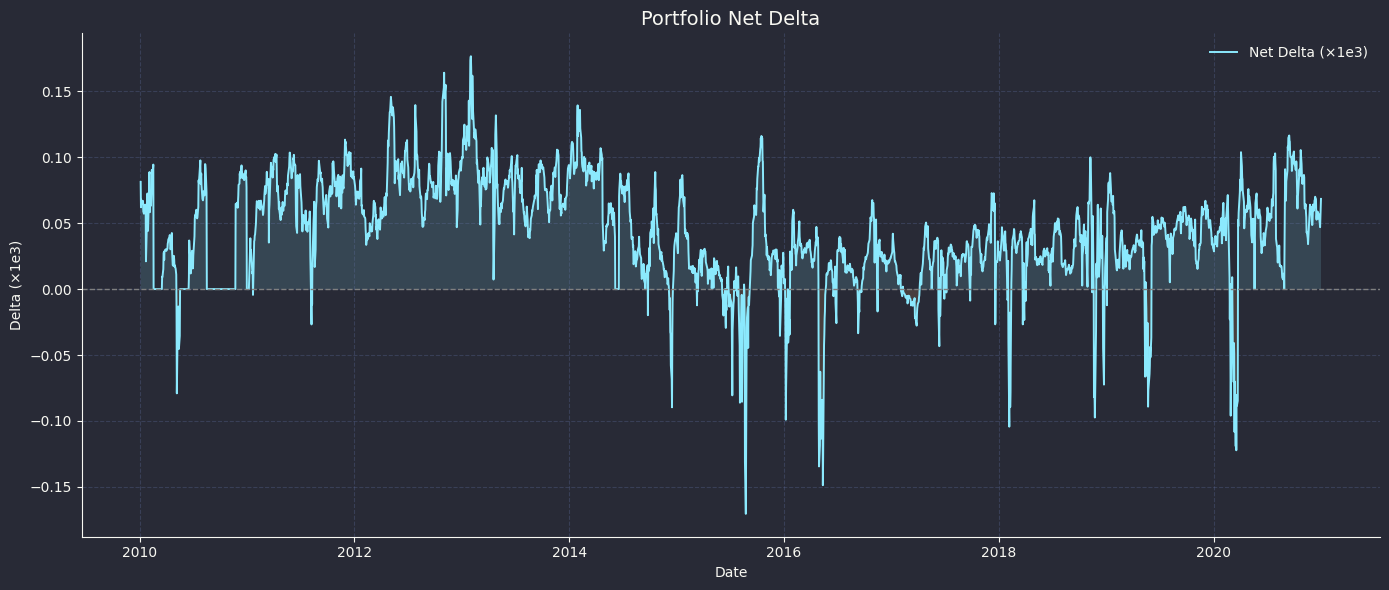

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
delta_scaled = delta 
ax.plot(delta.index, delta_scaled, linewidth=1.4, label='Net Delta (×1e3)')
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled < 0,  alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Delta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Delta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

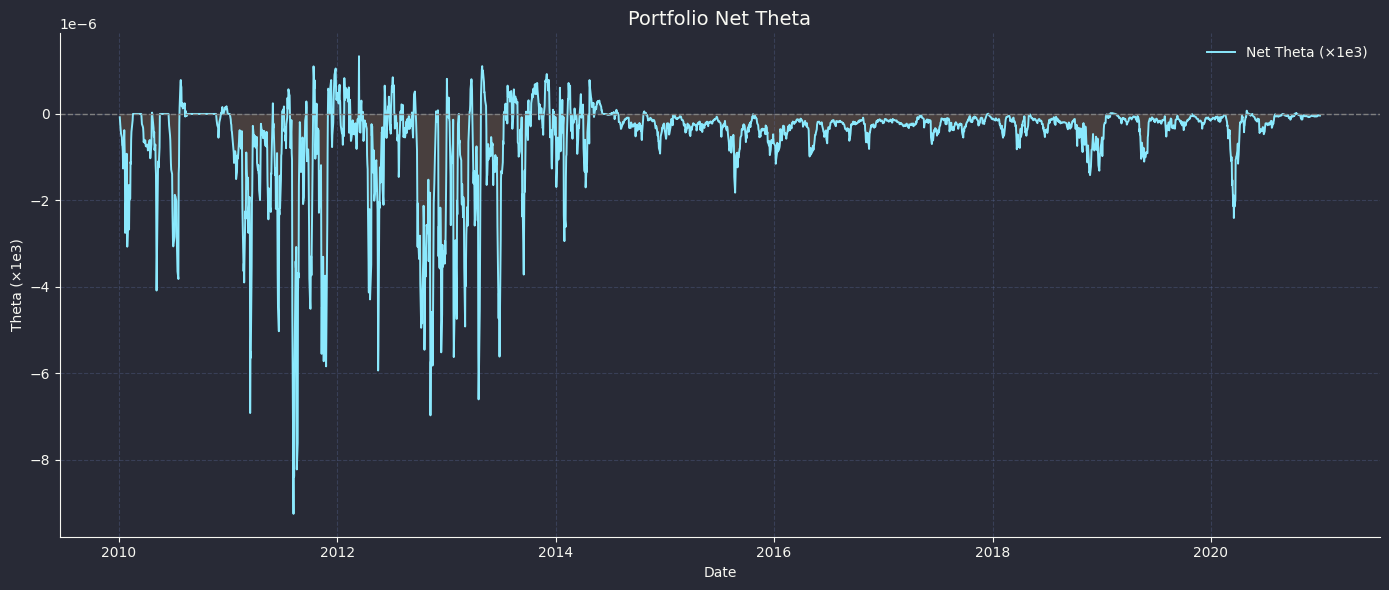

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
theta = theta / 1e3
ax.plot(theta.index, theta,  linewidth=1.4, label='Net Theta (×1e3)')
ax.fill_between(theta.index, 0, theta, where=theta >= 0, alpha=0.15)
ax.fill_between(theta.index, 0, theta, where=theta < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Theta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Theta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

C:\Users\cameronA\AppData\Local\Temp\ipykernel_4592\3981834457.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
[*********************100%***********************]  1 of 1 completed


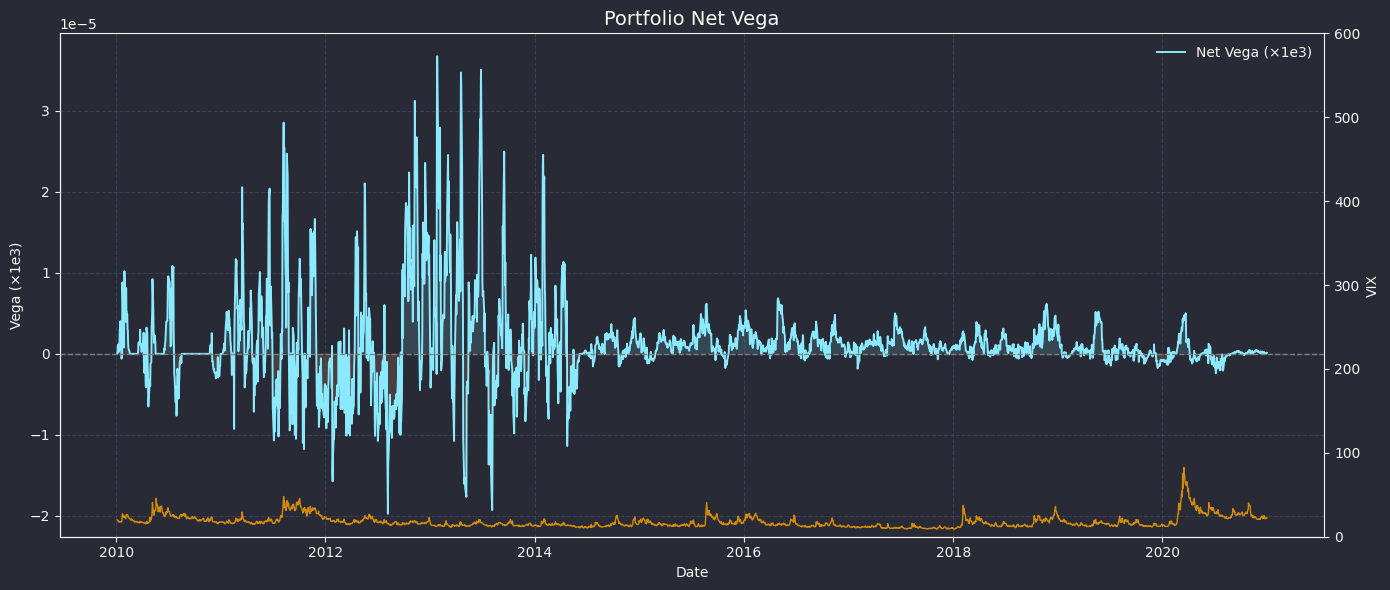

In [ ]:

import yfinance as yf

# Get VIX and align to allocation dates

before = data_manager.combined_outputs
allocation = before['multi_stock']['allocation_underlying_value'].dropna()[start:end]
vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
vix = vix['Close'].reindex(allocation.index).ffill()

fig, ax = plt.subplots(figsize=(14, 6))
vega_scaled = vega / 1e3
ax.plot(vega.index, vega_scaled,  linewidth=1.4, label='Net Vega (×1e3)')
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled >= 0, alpha=0.15)
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Vega', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Vega (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')


ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8, color='orange', label='VIX Level')
ax2.set_ylabel('VIX')
ax2.set_ylim(0, 600)
#ax.axvline(pd.Timestamp("2020-02-15"), color='gray', linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


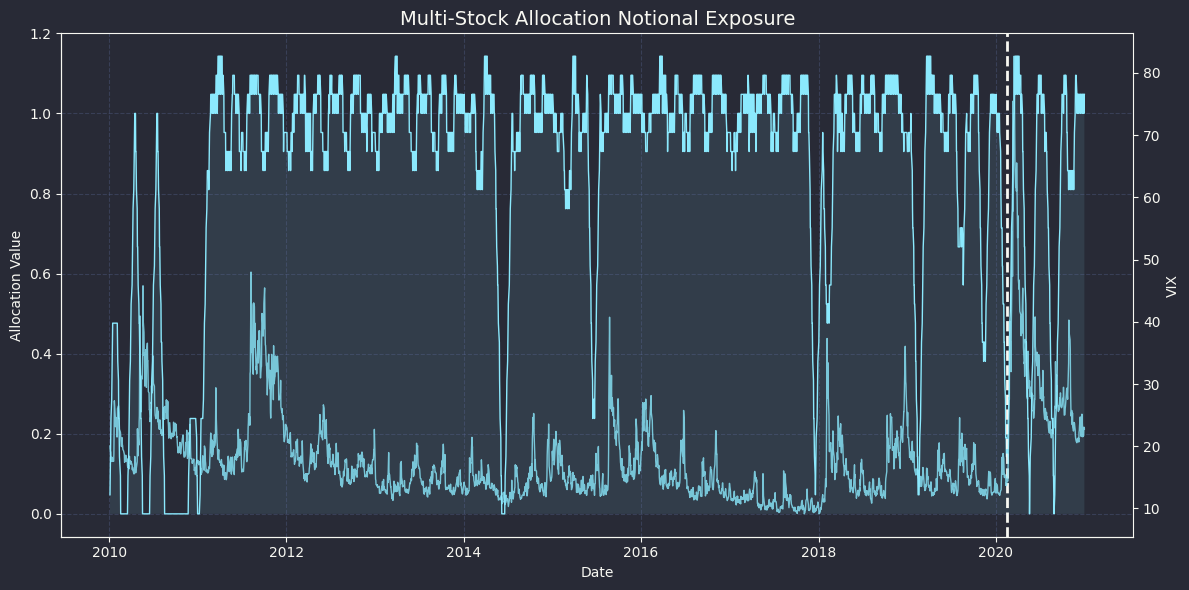

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))

# Left y-axis: allocation
ax.plot(allocation.index, allocation, linewidth=1)
ax.fill_between(allocation.index, allocation,  alpha=0.1)

ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Allocation Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Right y-axis: VIX
ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8)
ax2.set_ylabel('VIX')
ax.axvline(pd.Timestamp("2020-02-15"), linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


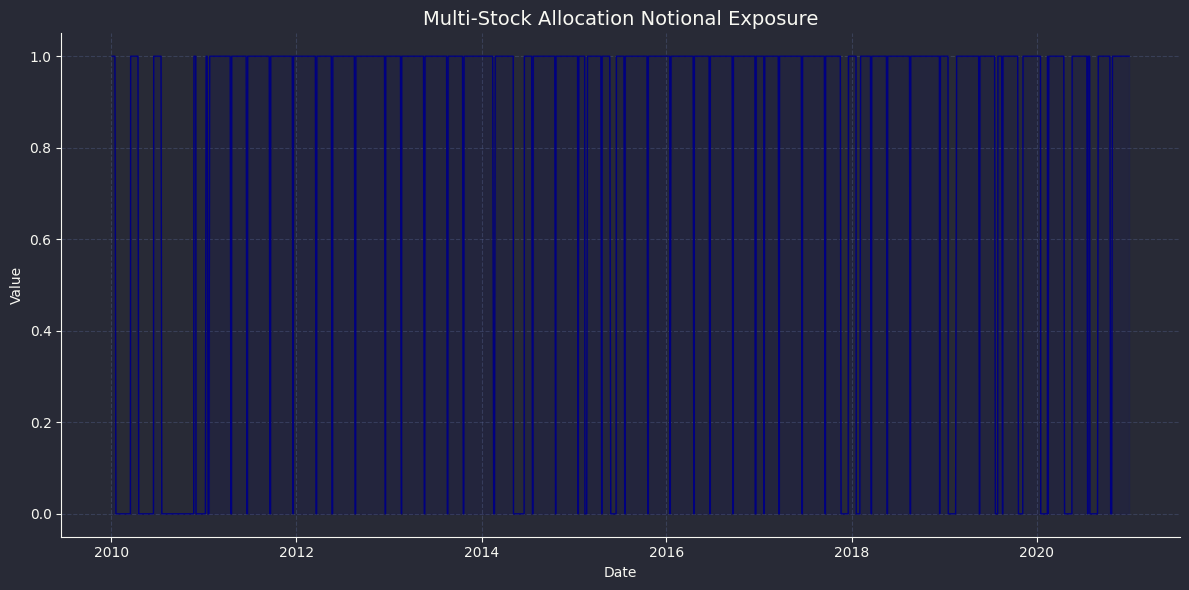

In [ ]:
before = data_manager.combined_outputs
allocation = before['multi_stock']['stocks_entered'].dropna()[start:end]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(allocation.index, allocation, color='navy', linewidth=1)
ax.fill_between(allocation.index, allocation, color='navy', alpha=0.1)
ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()